In [2]:
from tensorflow import keras
#import cv2
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import pandas as pd


In [3]:
path = "../imported_datasets/busi-with-gt/"
dir_list = [os.path.join(path,i) for i in os.listdir(path)]
size_dict = {}
for i,value in enumerate(dir_list):
    size_dict[os.listdir(path)[i]] = len(os.listdir(value))
size_dict 

import re
def clean(name):
    name = re.sub('[benign ().p]','',str(name))
    return name

In [4]:
df = pd.DataFrame(os.listdir(dir_list[0]))
# df = df.apply(str,axis=1)
df = df[0].apply(clean)
# print(df.info())
df = df[~df.str.contains('mask',regex =False)]
df = df.apply(int)
df_list = list(df)
type(df_list)
df_list.sort()
print(len(df_list))

387


In [5]:
img_size = 128
img_channel = 3
X_b , Xm_b , y_b = np.zeros((437,img_size,img_size,img_channel)) , np.zeros((437,img_size,img_size,img_channel)) , np.full(437,'benign') 
X_n , Xm_n , y_n = np.zeros((133,img_size,img_size,img_channel)) , np.zeros((133,img_size,img_size,img_channel)) , np.full(133,'normal') 
X_m , Xm_m , y_m = np.zeros((210,img_size,img_size,img_channel)) , np.zeros((210,img_size,img_size,img_channel)) , np.full(210,'malignant')


In [6]:
import os
img1_path = os.path.join(os.path.join(path,'benign'),os.listdir(os.path.join(path,'benign'))[1])

pil_img = load_img(img1_path,color_mode = 'rgb',target_size=(img_size,img_size))
img = img_to_array(pil_img)
img_shape = img.shape
print(img_shape)


(128, 128, 3)


In [7]:
def img_num(filename):
    
    val = 0
    
    for i in range(len(filename)) :
        if filename[i] == '(' :
            while True :
                i += 1
                if filename[i] == ')' :
                    break
                val = (val*10) + int(filename[i])
            break
    
    return val

for tumor_path in dir_list :
    for image in os.listdir(tumor_path) :
        p = os.path.join(tumor_path, image)
        pil_img = load_img(p,color_mode = 'rgb',target_size=(img_size,img_size))         # read image as  grayscale ans resize it
        
        if image[-5] == ')' :                                   #if real image 
            
            if image[0] == 'b' :
                X_b[img_num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                               # to X as benign , normal
                X_n[img_num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[img_num(image)-1]+= img_to_array(pil_img)
        else :                                                 #else masked image
            
            if image[0] == 'b' :
                Xm_b[img_num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                               # mask to y.
                Xm_n[img_num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                Xm_m[img_num(image)-1]+= img_to_array(pil_img)

In [8]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
Xm = np.concatenate((Xm_b, Xm_n, Xm_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

print(X.shape)
print(Xm.shape)
print(y.shape)
X /= 255.0
Xm /= 255.0

print(X.max())
print(Xm.min())

(780, 128, 128, 3)
(780, 128, 128, 3)
(780,)
1.0
0.0


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder  = OneHotEncoder()
# y = y.toarray()
y=encoder.fit_transform(y.reshape(y.shape[0],1))

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.15,shuffle=True,random_state=42)
Xm_train,Xm_test,ym_train,ym_test = train_test_split(Xm,y,test_size = 0.15,shuffle=True,random_state=42,stratify=y.toarray())

class_list = encoder.categories_
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(663, 128, 128, 3) (117, 128, 128, 3)
(663, 3) (117, 3)


In [10]:
from sklearn.metrics import f1_score,roc_auc_score,cohen_kappa_score
def evaluation(model,X_train,y_train,X_val,y_val,X_test,y_test,history):
    train_loss , train_acc = model.evaluate(X_train,y_train.toarray())
    val_loss, val_acc = model.evaluate(X_val,y_val.toarray())
    test_loss_value , test_accuracy = model.evaluate(X_test, y_test.toarray())
    y_pred = model.predict(X_test)
    y_pred_label = np.argmax(y_pred,axis=1)
    y_true_label = np.argmax(y_test,axis=1)
    f1_measure = f1_score(y_true_label,y_pred_label,average='weighted')
    roc_score = roc_auc_score(y_test.toarray(),y_pred)
    kappa_score = cohen_kappa_score(y_true_label,y_pred_label)
    print("Train accuracy = "+str(train_acc))
    print("Validation accuracy = "+str(val_acc))
    print('Test accuracy = ' + str(test_accuracy))
    print("f1_measure = "+str(f1_measure))
    print("KAPPA = "+str(kappa_score))
    print("roc_area = "+str(roc_score))

In [11]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def fit_evaluate(model,X_train,y_train,X_test,y_test,bs,Epochs,patience, cp_format):
    es = EarlyStopping(monitor='val_loss', mode='min', patience=patience,restore_best_weights=True, verbose=1)
    cp = ModelCheckpoint(filepath=cp_format, save_weights_only=True, verbose=1, save_freq=5*bs)
    X1_train,X_val,y1_train,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42,stratify = y_train.toarray())
    history = model.fit(X1_train,y1_train.toarray(),batch_size = bs,epochs=Epochs,validation_data = (X_val,y_val.toarray()), callbacks=[es, cp])
    evaluation(model,X1_train,y1_train,X_val,y_val,X_test,y_test,history)
    Train_Val_Plot(history.history['acc'],history.history['val_acc'],history.history['loss'],history.history['val_loss'])

In [12]:
import tensorflow as tf
base_model = tf.keras.applications.ResNet50(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=img_shape,
                pooling=None,
            )
for layer in base_model.layers:
    layer.trainable = False
    
def resnet():
    
    model = Sequential()
    model.add(base_model)
    
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
    
    return model

2022-06-24 07:46:35.705784: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-24 07:46:36.199227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79129 MB memory:  -> device: 0, name: A100-SXM-80GB, pci bus id: 0000:4f:00.0, compute capability: 8.0


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 32768)            131072    
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                      

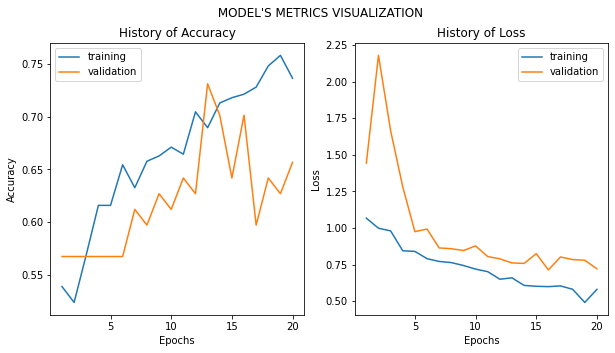

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 batch_normalization_3 (Batc  (None, 32768)            131072    
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                      

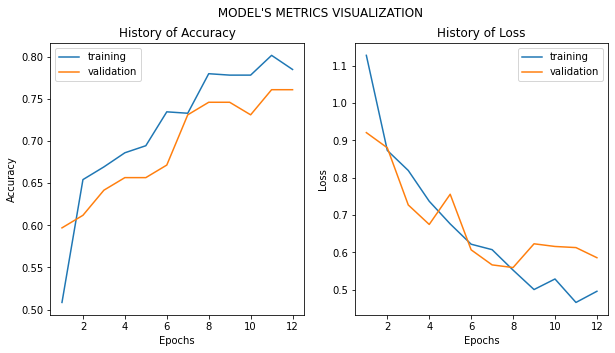

In [15]:
def Train_Val_Plot(accuracy,val_accuracy,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(accuracy) + 1), accuracy)
    ax1.plot(range(1, len(val_accuracy) + 1), val_accuracy)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
  

    plt.show()

model = resnet()
model.summary()
fit_evaluate(model,X_train,y_train,X_test,y_test,16,3000,4, "./checkpoints-raw/cp-{epoch:04d}/model.ckpt")

model = resnet()
model.summary()
fit_evaluate(model,Xm_train,ym_train,Xm_test,ym_test,16,3000,4, "./checkpoints-mask/cp-{epoch:04d}/model.ckpt")

In [16]:
def evaluate(model,X_test,y_test):
    test_loss_value , test_accuracy = model.evaluate(X_test, y_test.toarray())
    y_pred = model.predict(X_test)
    y_pred_label = np.argmax(y_pred,axis=1)
    y_true_label = np.argmax(y_test,axis=1)
    f1_measure = f1_score(y_true_label,y_pred_label,average='weighted')
    roc_score = roc_auc_score(y_test.toarray(),y_pred)
    kappa_score = cohen_kappa_score(y_true_label,y_pred_label)
    print('Test accuracy = ' + str(test_accuracy))
    print("f1_measure = "+str(f1_measure))
    print("KAPPA = "+str(kappa_score))
    print("roc_area = "+str(roc_score))
    
from PIL import Image
img = Image.open('../data/Dataset_BUSI_with_GT/test/malignant/malignant (161).png')
img = np.asarray(img.resize((128,128), Image.ANTIALIAS))
img = np.reshape(img,[1,128,128,3])

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
evaluate(model, X_test, y_test)

Evaluate on test data
4/4 [==============================] - 0s 12ms/step - loss: 1.1117 - acc: 0.2308
Test accuracy = 0.23076923191547394
f1_measure = 0.14042931455866778
KAPPA = 0.03703703703703709
roc_area = 0.5587777169827525
